# Thermodynamic formulation for transmembrane transport
## Marco Arieli Herrera-Valdez
### Facultad de Ciencias, UNAM

General formulation for transmembrane flux
\begin{eqnarray}
 \alpha
&=&
r  
\exp \left( b  \frac{\eta v-v_o}{v_T} \right)
\\
\beta 
&=&
r  
\exp \left( (b-1)  \frac{\eta v-v_o}{v_T} \right)
\\
\alpha -\beta 
&=&
r  \left[
\exp \left( b  \frac{\eta v-v_o}{v_T} \right)
- 
\exp \left((b-1) \frac{\eta v-v_o}{v_T} \right)
\right]
\end{eqnarray}

Transmembrane current 
\begin{eqnarray}
q \eta \left(\alpha -\beta \right)
=
q \eta r  \left[
\exp \left( b \frac{\eta v-v_o}{v_T} \right)
- 
\exp \left(  (b-1) \frac{\eta v-v_o}{v_T} \right)
\right]
\end{eqnarray}

In [1]:
import scipy as sc
import matplotlib.pylab as gr
import time
import matplotlib

In [2]:
matplotlib.rcParams.update({'font.size': 17})
matplotlib.rc('xtick', labelsize=17) 
matplotlib.rc('ytick', labelsize=17)
%matplotlib inline

__Auxiliary functions__

\begin{eqnarray}
\alpha-\beta
&=&
r  \left[
\exp \left( -b  \frac{\Delta G}{kT} \right)
- 
\exp \left((1-b) \frac{\Delta G}{kT} \right)
\right]
\end{eqnarray}

#### Weighted difference of exponential functions and approximations}

\begin{equation}
\varphi (u;s) = e^{su} -  e^{(s-1)u}.
\end{equation} 
Notice that $\varphi (u;1/2)= 2\sinh(u)$, and that the Taylor expansion of  $\varphi$ around $u=0$ is
\begin{eqnarray*}
\varphi (u;s) &=& \sum_{n=0}^{\infty} \frac{s^n u^n}{n!} - \sum_{n=0}^{\infty} \frac{(s-1)^n u^n}{n!},
\\
&=& \sum_{n=0}^{\infty} \left[ s^n- (s-1)^n \right] \frac{u^n}{n!} 
%\\
%&=& \sum_{n=0}^{\infty} \frac{u^n}{n!} \left[ s^n-\sum_{k=0}^n \frac{n!}{(n-k)! k! \right]  (-1)^k s^{n-k}} 
\\
&=& \sum_{n=0}^{\infty} u^n \left( \sum_{k=0}^{n-1} \frac{(-1)^k s^{n-1-k} }{(n-1-k)! k!} \right)
\\
&=& u + u^2 \left(\frac{2s-1}{2}\right) + u^3 \left(\frac{3s^2-3s+1}{3!}\right) + ...
\\
&=& u \lbrace 1+ u \left(\frac{2s-1}{2}\right) + u^2 \left(\frac{3s^2-3s+1}{3!}\right) + ... \rbrace
\end{eqnarray*}


In [3]:
def genFlux(deltaGkT, rect=0.5, A=1.0, degree="exp"):
    if degree=="exp":
        f = A *((sc.exp(-rect * deltaGkT)-(sc.exp(((1-rect)* deltaGkT)))))
    elif degree=="3":
        f =  A * deltaGkT * (1+ ((2*rect-1)/2)* deltaGkT + ((3*rect**2 - 3*rect +1)/6)* (deltaGkT**2))
    elif degree=="1":
        f =  A * deltaGkT
    return f


#### Current from the generic flux

In [4]:
def genCurrent(v,v_r, eta, rect=0.5, A=1.0, vT=26.7, degree="exp"):
    aa= (eta*v-v_r)/vT
    if degree=="exp":
        i = A *((sc.exp(rect * aa)-(sc.exp(((rect-1)* aa)))))
    elif degree=="3":
        i =  A * aa * (1+ (rect -1/2)* aa + ((3* rect**2 -3*rect +1)/6)* (aa**2))
    elif degree=="1":
        i =  A * aa
    return i

In [5]:
def nExpSub(y, s=0.5):
    ee = sc.exp(y)
    return ee**(s-1) - ee**(s)

def nExpSubConc(y, s=0.5, inC=1.0, outC=1.0):
    ee = sc.exp(y)*inC/outC
    return ee**(1-s) - ee**(-s)

def nExpSum(y, s=0.5):
    ee = sc.exp(y)
    return ee**(s-1)+ ee**(s) 

def nExpSigmoid(y):
    ee = sc.exp(y)
    return ee/(1+ee)

def vBoltzmann(tempCelcius=22.0):
    """Calculates the Boltzmann or thermal potential at the specified temperature"""
    return kBoltzmann*(zeroT+tempCelcius)/eCharge

def vNernst(cIn=140.0, cOut=5.0, val=1.0, tempCelcius=22.0):
    """Calculates the Nernst potential
    vx=vNernst(cIn=140.0, cOut=5.0, val=1.0, tempCelcius=22.0)
    """
    vT= kBoltzmann*(zeroT+tempCelcius)/eCharge
    vN= vT * sc.log(cOut/cIn) / val
    return vN

def addSuffix(p,suff='',removeOriginal=1):
    pa= p.copy()
    for key, val in p.items():
        pa[key+suff]=val
        if removeOriginal:
            pa.pop(key)
    return pa

def calcReversalPotentials(parDict):
    parDict['v_T'] = vBoltzmann(parDict['tempCelcius'])
    parDict['v_AMPA']=0.0
    #parDict['v_ATP']= -450.0; 
    parDict['v_Cl']=vNernst(cIn=parDict['in_Cl'], cOut=parDict['out_Cl'], val=-1.0, tempCelcius=parDict['tempCelcius'])
    parDict['v_Ca']=vNernst(cIn=parDict['in_Ca'], cOut=parDict['out_Ca'], val=2.0, tempCelcius=parDict['tempCelcius'])
    parDict['v_Na']=vNernst(cIn=parDict['in_Na'], cOut=parDict['out_Na'], val=1.0, tempCelcius=parDict['tempCelcius'])
    parDict['v_Ka']=vNernst(cIn=parDict['in_Ka'], cOut=parDict['out_Ka'], val=1.0, tempCelcius=parDict['tempCelcius'])
    parDict['v_NaKa'] = 3*parDict['v_Na'] - 2*parDict['v_Ka'] + parDict['v_ATP']
    parDict['v_NaCa'] = - 3*parDict['v_Na'] + 2*parDict['v_Ca'] 
    return parDict


def findSpikes(dvdt,thresh=100.0):
    i=sc.where(dvdt>thresh)[0];#print(i)
    sInds=list()
    if len(i)>0:
        di=i[1:]-i[:-1]
        sInds.append(i[0])
        for n in sc.arange(len(i)-1):
            if i[n+1]-i[n]>1:
                sInds.append(i[n+1])
    #print(sInds); print(p["sampTimes"][sInds])
    return sInds

def countSpikes(dvdt, thresh=100.0, report=1):
    n = len(findSpikes(dvdt,thresh))
    if report==1:
        print("Found %d spikes"%n)
    return n

In [6]:
# Physical constants
eCharge=1.60217733e-19 # Coulombs
kBoltzmann=1.38065812e-20 #mJ/K
zeroT=273.15 #deg Kelvin

# Biophysical and numerical parameters
numerics = {'timeMin':0.0, 'timeMax':10.0, 'timeStep':0.025,'rTol':1e-4, 'aTol':1e-9}

physicalConstants={'eCharge':1.60217733e-19, 'kBoltzmann':1.38065812e-20, 'zeroT':273.15, 
                   "Faraday":96485.3329, #
                   "NA":6.02214086e23}

biophysMembrane={'in_Na': 10.0, 'out_Na': 150.0, 'in_Ka': 140.0, 'out_Ka': 5.0,
                 'out_Ca': 2., 'in_Ca': 1e-4, 'in_Cl': 10.0, 'out_Cl': 150.0,
                 'Cm': 20.0,'tempCelcius':37.0, 'v_ATP':-450.0}

biophysCalcium={'kc': 2.5e-4, 'rc':1.0/250.0,
    'c_Min':1e-5, 'c_Slope': 1.5e4,'c_half':5.6e-4,'c0':1e-4, 'mMmillionC':5200.0}
biophysNaKa={#'Name':'Natrium-Kalium ATPase',
    'eta':1.0,
    'a':1.0e-3, 'rect':0.5}  
biophysNaCa={#'Name':'Natrium-Calcium pump',
    'eta':-1.0,
    'a':0.0, 'rect':0.5}  
biophysKaD={#'Name':'Kalium delayed rectifier channel',
    'eta':1.0,
    'a':1.0e-3, 'rect':0.5,
    'v_half_Act': -1.0, 'gain_Act': 3.0, 'rate_Act':2.5, 'exp_Act':1.0, 'bias_Act': 0.3}  
biophysNaT={#'Name':'Natrium transient channel',
    'eta':-1.0,
    'a':1.0e-3, 'rect':0.5,
    'v_half_Act': -25.0, 'gain_Act': 4.0, 'rate_Act':10.0, 'exp_Act':1.0, 'bias_Act': 0.3,
    'v_half_Inac': -67.5, 'gain_Inac':-4.3, 'rate_Inac':0.1, 'exp_Inac':1.0, 'bias_Inac': 0.2}
biophysCa13={#'Name':'Cav13 L-type channel',
    'eta':-2.0,
    'a':0.0e-3, 'rect':0.5,
    'v_half_Act': -20.0, 'gain_Act': 4.0, 'rate_Act':10.0, 'exp_Act':1.0, 'bias_Act': 0.3}

#### Parameters for simulations of membrane potential dynamics

In [7]:
p= dict()
p.update(biophysMembrane)
p.update(numerics)
p.update(physicalConstants)
p.update(addSuffix(biophysKaD,suff='_KaD'))
p.update(addSuffix(biophysNaT,suff='_NaT'))
p.update(addSuffix(biophysCa13,suff='_Ca13'))
p.update(addSuffix(biophysNaCa,suff='_NaCa'))
p.update(addSuffix(biophysNaKa,suff='_NaKa'))
p.update(addSuffix(biophysCalcium,suff='_Ca'))
p= calcReversalPotentials(p)
print('v_T=%g'%p['v_T'])
print(p)

v_T=26.7268
{'in_Na': 10.0, 'out_Na': 150.0, 'in_Ka': 140.0, 'out_Ka': 5.0, 'out_Ca': 2.0, 'in_Ca': 0.0001, 'in_Cl': 10.0, 'out_Cl': 150.0, 'Cm': 20.0, 'tempCelcius': 37.0, 'v_ATP': -450.0, 'timeMin': 0.0, 'timeMax': 10.0, 'timeStep': 0.025, 'rTol': 0.0001, 'aTol': 1e-09, 'eCharge': 1.60217733e-19, 'kBoltzmann': 1.38065812e-20, 'zeroT': 273.15, 'Faraday': 96485.3329, 'NA': 6.02214086e+23, 'eta_KaD': 1.0, 'a_KaD': 0.001, 'rect_KaD': 0.5, 'v_half_Act_KaD': -1.0, 'gain_Act_KaD': 3.0, 'rate_Act_KaD': 2.5, 'exp_Act_KaD': 1.0, 'bias_Act_KaD': 0.3, 'eta_NaT': -1.0, 'a_NaT': 0.001, 'rect_NaT': 0.5, 'v_half_Act_NaT': -25.0, 'gain_Act_NaT': 4.0, 'rate_Act_NaT': 10.0, 'exp_Act_NaT': 1.0, 'bias_Act_NaT': 0.3, 'v_half_Inac_NaT': -67.5, 'gain_Inac_NaT': -4.3, 'rate_Inac_NaT': 0.1, 'exp_Inac_NaT': 1.0, 'bias_Inac_NaT': 0.2, 'eta_Ca13': -2.0, 'a_Ca13': 0.0, 'rect_Ca13': 0.5, 'v_half_Act_Ca13': -20.0, 'gain_Act_Ca13': 4.0, 'rate_Act_Ca13': 10.0, 'exp_Act_Ca13': 1.0, 'bias_Act_Ca13': 0.3, 'eta_NaCa': -1

## Rectification
Biasing the flux in one of the two directions.

In [8]:
# -----------------------------------
# Rectification in flux
# -----------------------------------
# -----------------------------------
# Figure: Rectification
# -----------------------------------
def rectificationCurves(fs=15,figName="alpha-beta(DeltaG).png"):
    deltaGkT = sc.arange(-3,3,0.01)
    s = [0.1,0.5,0.9]
    y = list()
    f0= gr.figure(figsize=(15,7))
    gr.ioff()
    mrs=['k--','b', 'r-.']
    lws=[2,2,3]
    trs=[1,0.99,0.7]
    #rect=["backward bias", "symmetric", "forward bias"]
    rect=[r"target$\rightarrow$source bias",r"unbiased",r"source$\rightarrow$target bias"]
    yy = deltaGkT
    strBwd=r"$1-e^{ \Delta G/(\mathrm{kT})}$"
    strSym=r"$e^{-\Delta G/(2\mathrm{kT})}-e^{\Delta G/(2\mathrm{kT})}$"
    strFwd=r"$e^{- \Delta G/(\mathrm{kT})}-1 $"
    funcs= [strBwd, strSym, strFwd]
    for n in sc.arange(len(s)):
        y= genFlux(deltaGkT,rect=s[n], A=1.0, degree="exp")
        #gr.plot(deltaGkT, y, mrs[n], lw=lws[n], alpha=trs[n], label=r'b=%g'%(s[n]))
        gr.plot(deltaGkT, y, mrs[n], lw=lws[n], alpha=trs[n], label=r'%s, %s'%(funcs[n], rect[n]))
    gr.plot([deltaGkT.min(), deltaGkT.max()], [0,0], 'k:')
    gr.plot([0,0],[-10,10], 'k:')
    str0=r"$\Delta G/(\mathrm{kT})$"
    gr.text(-1,3.0, r"Net source$\rightarrow$target flow",fontsize=fs,rotation=0)
    gr.text(-1.5,-0.5,r'Thermodynamically favorable',fontsize=fs)
    gr.text(0.5,0.25,r'Thermodynamically unfavorable',fontsize=fs)
    gr.text(.05,-3.0,r"Net target$\rightarrow$source flow",fontsize=fs,rotation=0)
    gr.xlabel(str0,fontsize=fs)
    gr.ylabel(r'$\varphi\left( -\Delta G /\left( \mathrm{kT} \right), b\right)$',fontsize=fs)
    gr.legend(loc="upper right",fontsize=fs)
    gr.ylim(-5,5); gr.xlim(-2,2)
    f0.subplots_adjust(left=0.075, right=0.98, top=0.98, bottom=0.12)
    gr.ion(); gr.draw()
    if len(figName)>0:
        f0.savefig(figName)
    return f0

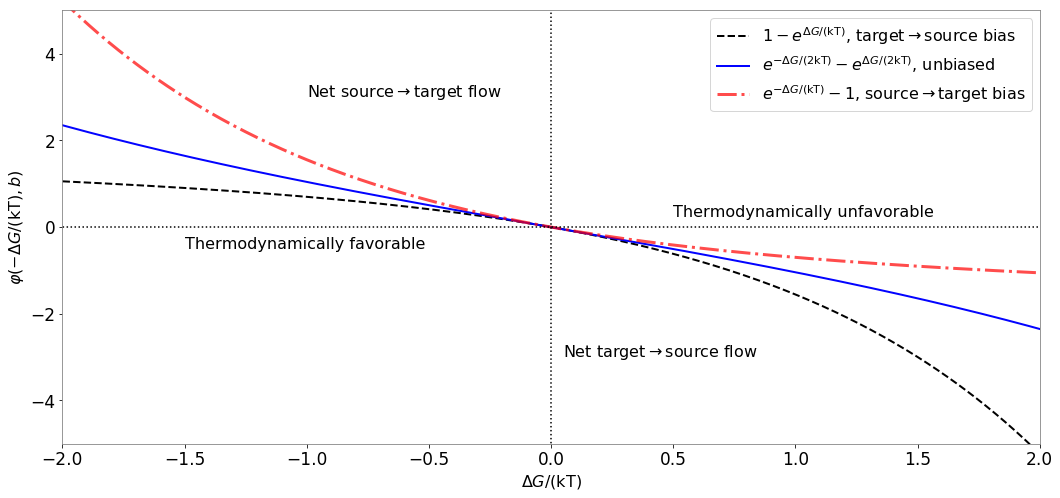

In [9]:
figRectifyingCurrents=1
if figRectifyingCurrents:
    f0=rectificationCurves(fs=16,figName="./ttt_Figures/alpha-beta_DeltaG.png")
    #f0=rectificationCurves(fs=19,figName="")

**Note: The correspondence between rectification values and the type of rectification for currents (inward/outward) depends on the direction of ionic transport $\eta$**

For K channels, inward rectification corresponds to $b_K\approx 0$ and outward rectification corresponds to $b_K\approx 1$.

In [10]:
# K-channel rectification
def rectificationCurves(rects = sc.array([0.1,0.5,0.9]),vS= sc.arange(-150,10,0.1),figName="rectificationK.png",fs=16):
    """Plot K-electrodiffusion curves for different values of the bias term b_K"""
    f0=gr.figure(figsize=(15,7)); gr.ioff(); rows=1; cols=1
    ax=f0.add_subplot(rows,cols,1)
    rect=["inward","non rectifying","outward"]
    n=0
    for r in rects:
        iE=genCurrent(v=vS, v_r=-90.0,eta=1.0, rect=r, degree= "exp")
        i3=genCurrent(v=vS, v_r=-90.0,eta=1.0, rect=r, degree= "3")
        ax.plot(vS, iE, lw=3, label=r'b_K= %g, %s'%(r,rect[n]))
        ax.plot(vS, i3, '--', lw=1, label=r'b_K= %g (%s)'%(r,'cubic'))
        n=n+1
    ax.plot([vS.min(), vS.max()],[0,0],'k:')
    ax.legend(loc='lower right', ncol=3, fontsize=fs)
    ax.set_xlim(vS.min(),vS.max()); ax.set_ylim(-5,10); 
    ax.set_ylabel('pA',fontsize=fs); ax.set_xlabel('mV',fontsize=fs) 
    gr.ion(); gr.draw()
    if len(figName)>0:
        f0.savefig(figName)
    return f0


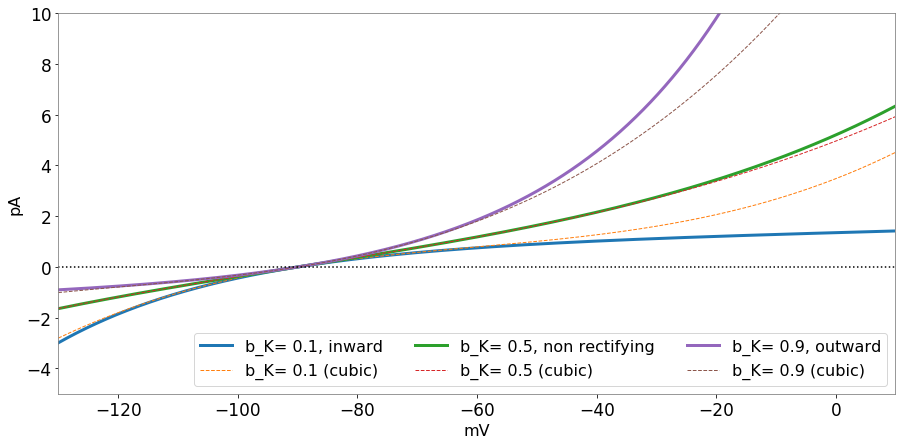

In [11]:
rectificationK=1
if rectificationK>0:
    figureName="./ttt_Figures/rectificationK.png"
    f0=rectificationCurves(rects = sc.array([0.1,0.5,0.9]),vS= sc.arange(-130,10,0.1),figName=figureName)

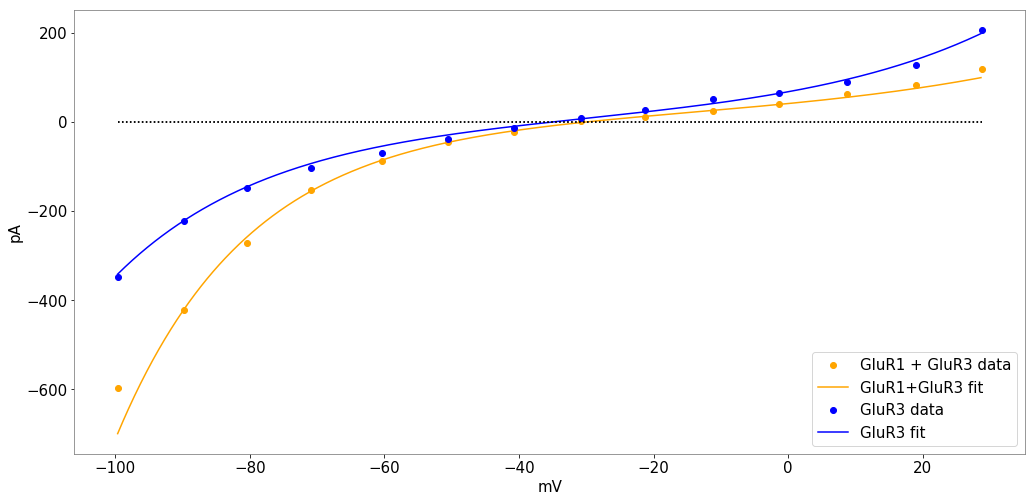

In [12]:
fs=15
matplotlib.rcParams.update({'font.size': fs})
matplotlib.rc('xtick', labelsize=fs)
matplotlib.rc('ytick', labelsize=fs)

fnGluR13='dataFromFigures/CaPermeabilityKA-AMPA-GatedGluR_Hollman+etal_1991_Fig3B_GluR13.txt'
fnGluR3='dataFromFigures/CaPermeabilityKA-AMPA-GatedGluR_Hollman+etal_1991_Fig3B_GluR3.txt'
GluR13=sc.loadtxt(fnGluR13,delimiter=',').transpose()
GluR3=sc.loadtxt(fnGluR3,delimiter=',').transpose()
#
vC = sc.arange(GluR3[0].min(),GluR3[0].max(),0.1)
v_R = 2*(120) + 3 * (-90)
zCa = 2.0; zK=1; z = 3*zK-zCa

def rectifyingCurrent_Fit(v,vr,vT,s=1.0,rect=0.5,a=1.0):
    vv = s*(v-vr)/vT
    uu = sc.exp(rect*vv)
    return a * uu * (1- sc.exp(-vv))

v_T=vBoltzmann(tempCelcius=22.0)
I13= rectifyingCurrent_Fit(v=vC,vr=-30.0, vT=v_T, s=2.0, rect=0.35, a=20.0)
I3= rectifyingCurrent_Fit(v=vC,vr=-35.0, vT=v_T, s=2.0, rect=0.45, a=21.0)
#
fig = gr.figure(figsize=(15,7)); gr.ioff(); rows=1; cols=1;
ax1= fig.add_subplot(rows,cols,1)
ax1.plot(GluR13[0],GluR13[1],'o',color='orange',label='GluR1 + GluR3 data')
ax1.plot(vC,I13,'-',color='orange',label=r'GluR1+GluR3 fit')
ax1.plot(GluR3[0],GluR3[1],'o',color='blue',label='GluR3 data')
ax1.plot(vC,I3,'-',color='blue',label=r'GluR3 fit')
ax1.plot([GluR3[0].min(),GluR3[0].max()],[0,0],'k:',label='')
ax1.plot([GluR3[0].min(),GluR3[0].max()],[0,0],'k:',label='')
ax1.set_xlabel('mV'); ax1.set_ylabel('pA')
ax1.legend(loc='lower right',fontsize=fs);
gr.subplots_adjust(left=0.1,bottom=0.1,top=0.98,right=0.98)
gr.ion(); gr.draw()
gr.savefig('./ttt_Figures/AMPA-KA_GluR1-GluR3_fit.png')


## Membrane potential dynamics

General minimal model for transmembrane potential
\begin{eqnarray}
\partial_t v &=& - \sum_{i=1}^{n} A_i p_i(v) \psi_i(v)
\end{eqnarray}
where $\psi_i(v)$ models the current mediated by the $i$th transport mechanism


#### Numerics
Runge-Kutta of order 2.

In [13]:
def RK2_Cardiac(pars, f, ic, stepSize, nSteps):
    """Second-order Runge-Kutta method to solve x' = f(x,t) with U(t[0]) = U0.
    NOTES:
        This version is based on the algorithm presented in "Numerical
        Analysis", 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
    """
    U=sc.zeros((nSteps, sc.prod(sc.shape(ic))),"float64")
    U[0]=ic
    for i in sc.arange(nSteps-1):
        t = stepSize * i
        #print(f(U[i],pars))
        k1 = stepSize * f( U[i], pars) / 2.0
        U[i+1] = U[i] + stepSize * f( U[i] + k1, pars)
    return U.transpose()


## Cardiac pacemaking

In [24]:
# ------------------------------------------
# Ca-Ka pacemaker dynamics 3D
# ------------------------------------------
def CaL13KaDNaKaNaCa(u,p):
    v,w,c=u 
    p["v_Ca"] = p['v_T']*0.5 * sc.log(p["out_Ca"]/c) # - 2*0.5*log(out_Ca/c)
    p['v_NaCa'] =  3 * p["v_Na"]- 2 * p["v_Ca"]
    m13Inf = nExpSigmoid(p['gain_Act_Ca13']*(v-p['v_half_Act_Ca13'])/p['v_T'])
    yyKaD = p['gain_Act_KaD']*(v-p['v_half_Act_KaD'])/p['v_T']
    wInf = nExpSigmoid(yyKaD)
    wRate = p['rate_Act_KaD'] * nExpSum(yyKaD,s=p['bias_Act_KaD'])
    #
    jCa13 = genCurrent(v, v_r=p["eta_Ca13"] * p["v_Ca"], eta=p["eta_Ca13"], rect=p["rect_Ca13"], A=p['a_Ca13']*p["eta_Ca13"],vT=p['v_T'],degree=p["degree"])
    jNaCa = genCurrent(v, v_r=p['eta_NaCa'] * p["v_NaCa"], eta=p["eta_NaCa"], rect=p["rect_NaCa"], A=p['a_NaCa']*p["eta_NaCa"],vT=p['v_T'],degree=p["degree"])
    jKaD = genCurrent(v, v_r=p["eta_KaD"] *p["v_Ka"], eta=p["eta_KaD"], rect=p["rect_KaD"], A=p["a_KaD"]*p["eta_KaD"],vT=p['v_T'],degree=p["degree_KaD"])
    jNaKa = genCurrent(v, v_r=p["eta_NaKa"] *p["v_NaKa"], eta=p["eta_NaKa"], rect=p["rect_NaKa"], A=p['a_NaKa']*p["eta_NaKa"],vT=p['v_T'],degree=p["degree_NaKa"])
    dv = - (jCa13*(1-w)*m13Inf + jKaD*w + jNaKa +jNaCa)/p['Cm'] 
    dw = (w**p['exp_Act_KaD']) * (wInf-w)* wRate
    dc= p['rc_Ca'] * (p['c_Min_Ca']-c) - p['kc_Ca']* (jCa13*(1-w)*m13Inf - jNaCa)
    #print("v_Ca=%g, v_r_Ca=%g, etaCa13=%g, iCaL13=%g, "%(p["y_Ca13"]*p["v_T"],p["y_r_Ca13"]*p["v_T"],p["eta_Ca13"],jCa13*(1-w)))
    #if p['verboseSimulation']:
    #    print(t,c,w,y,dv, dw, dc)
    return sc.array([dv,dw,dc])

In [25]:
def calcCardiac3DOrbit(rhs,u0,p, startInd=1000, dvdtThresh=3.0):
    orbit= RK2_Cardiac(pars=p, f=rhs, ic=u0, stepSize=p["timeStep"], nSteps=len(p["timeSamples"]))
    #orbit = solveRK4(p)
    #orbit = sc.integrate.odeint(rhs, u0, p['timeSamples'], args=(p,),rtol=p['rTol'], atol=p['aTol']).transpose()
    print("Done calculating the numerical solution")
    mSecs= p['timeSamples'][startInd:]; 
    mSecs=mSecs-mSecs[0]
    vOrbit= orbit[0][startInd:]
    wOrbit= orbit[1][startInd:]
    cOrbit= orbit[2][startInd:]
    #
    dvdtOrbit= sc.zeros(len(vOrbit))
    dvdtOrbit[1:] = (vOrbit[1:]- vOrbit[0:-1]) / p['timeStep']
    dwdtOrbit= sc.zeros(len(vOrbit))
    dwdtOrbit[1:] = (wOrbit[1:]- wOrbit[0:-1]) / p['timeStep']
    vCa= 0.5 * p["v_T"] * sc.log(p["out_Ca"]/cOrbit) 
    p["v_r_Ca13"] = p["eta_Ca13"] * vCa
    vNaCa =  3 * p["v_Na"]- 2 * vCa
    m13Inf = nExpSigmoid(p['gain_Act_Ca13']*(vOrbit-p['v_half_Act_Ca13'])/p['v_T'])
    yyKaD = p['gain_Act_KaD']*(vOrbit-p['v_half_Act_KaD'])/p['v_T']
    wInf = nExpSigmoid(yyKaD)
    wRate = p['rate_Act_KaD'] * nExpSum(yyKaD,s=p['bias_Act_KaD'])
    #
    jCa13 = genCurrent(vOrbit, v_r = p["eta_Ca13"] * vCa, eta=p["eta_Ca13"], rect=p["rect_Ca13"], A=p['a_Ca13']*m13Inf*p["eta_Ca13"],vT=p['v_T'],degree=p["degree"])
    jNaCa = genCurrent(vOrbit, v_r= p["eta_NaCa"] * vNaCa, eta=p["eta_NaCa"], rect=p["rect_NaCa"], A=p['a_NaCa']*p["eta_NaCa"],vT=p['v_T'],degree=p["degree"])
    jKaD = genCurrent(vOrbit, v_r= p["eta_KaD"] *p["v_Ka"], eta=p["eta_KaD"], rect=p["rect_KaD"], A=p["a_KaD"]*p["eta_KaD"],vT=p['v_T'],degree=p["degree"])
    jNaKa = genCurrent(vOrbit, v_r= p["eta_NaKa"] *p["v_NaKa"], eta=p["eta_NaKa"], rect=p["rect_NaKa"], A=p['a_NaKa']*p["eta_NaKa"],vT=p['v_T'],degree=p["degree"])    
    #
    iKd = wOrbit * jKaD
    iNaK = jNaKa
    iCaL13 = (1-wOrbit)*jCa13
    iNaCa = jNaCa
    iTot= iNaK+iKd+iCaL13+iNaCa
    #wInv= wInverse(wOrbit,p["v_half_Act_KaD"],p["gain_Act_KaD"],p["v_T"])
    nSpikes =countSpikes(dvdtOrbit,dvdtThresh)
    d ={'v':vOrbit,'w':wOrbit,'dvdt':dvdtOrbit, #'wInv':wInv, 
        'dwdt':dwdtOrbit, 
        'mSecs':mSecs, 'in_Ca':cOrbit, 'v_Ca':vCa, 'v_NaCa':vNaCa,
        'iKd': iKd, 'iCaL13':iCaL13, 'iNaK': iNaK, 'iNaCa': iNaCa, 'iTot':iKd+iCaL13+iNaK+iNaCa,
        'nSpikes':nSpikes}
    print("Found %d spikes"%d['nSpikes'])
    return d

In [26]:
def approachLimitCycle(p3d,maxTime=1000.0, sRateKHz=50.0, nIter=10):
    p3d["timeStep"]= 1/sRateKHz; p3d['timeMax']=maxTime
    p3d['timeSamples'] = sc.arange(0,p3d['timeMax'],p3d['timeStep'])
    v0 = -30.0; c0= 2*p3d['c_Min_Ca'];
    w0 = nExpSigmoid(p3d['gain_Act_KaD']*(v0-p3d['v_half_Act_KaD'])/p3d['v_T'])
    p3d['ic']=sc.array([v0, w0, c0])
    d=calcCardiac3DOrbit(p3d["rhs"],p3d["ic"],p3d, startInd=0)
    for n in sc.arange(nIter):
        print('Iteration %d'%n)
        ic=sc.array([d["v"][-1],d["w"][-1],d["in_Ca"][-1]])
        if n<nIter-1:
            d=calcCardiac3DOrbit(p3d["rhs"], ic, p3d, startInd=0)
        else:
            d=calcCardiac3DOrbit(p3d["rhs"], ic, p3d, startInd=0)
    return d

### Sinoatrial node pacemaking dynamics

In [27]:
# Parameters
def cardiacBasePars():
    p3d= p.copy()
    p3d['rhs']=CaL13KaDNaKaNaCa
    p3d["degree"]='exp'; p3d["degree_NaKa"]='exp'; 
    p3d["degree_KaD"]='exp'; 
    p3d["nDim"]=3; p3d["nNeur"]=1
    p3d['verboseSimulation']=0.
    p3d["v_ATP"]=-420.0    
    p3d["out_Ka"]=5.0;
    p3d["out_Na"]=140.0;p3d["in_Na"]=15.0; 
    p3d["cm"] = 0.01 # pF/um2
    # cSAN spindle cell with a 4/2 ratio between mayor and minor radii, 
    # pSAN spindle cell with a 8/3 ratio between mayor and minor radii, 
    # approximated as a revolution surface from a cosine between -pi/2 and pi/2
    #p3d["mayorRadius"] = 4*sc.pi; p3d["minorRadius"] = 2*sc.pi
    p3d["mayorRadius"] = 4*sc.pi; p3d["minorRadius"] = 1.75*sc.pi
    p3d["membArea"]= 8* p3d["mayorRadius"]*p3d["minorRadius"] * sc.pi
    p3d["Cm"] = 30.0 #pF
    p3d["membArea"]= p3d["Cm"]/p3d["cm"]  
    # Ca concentrations in mM
    p3d["in_Ca"]= 1e-1; p3d["out_Ca"]=1.50e3
    p3d["kc_Ca"]= 2e1/p3d["Faraday"]
    p3d["rc_Ca"] = 1/50.0
    p3d["c_Min_Ca"]=1e-1
    print("The membrane area is %g um2"%p3d["membArea"])
    print("The conversion constant from current in pA to nMols/msec is %g Mols/Coul"%p3d["kc_Ca"])
    print("The membrane capacitance is %g pF"%p3d["Cm"])
    #p3d["kc_ca"]= 1e-3
    # Current amplitudes in pA
    p3d['a_Ca13'] = 1;
    p3d['a_KaD'] = 7e2
    p3d['a_NaCa'] = 3.0 #2.5 #* p3d["A_Ca13"]
    p3d['a_NaKa'] = 1.0 #* p3d['A_Ca13'] 
    p3d["Rin"] = 4.0 #GOhm
    #p3d["A_NaKa"] = p3d["v_T"]/p3d["Rin"] #mV/GOhm = mV* nS = pF
    p3d['rate_Act_KaD'] = 0.05; p3d["exp_Act_KaD"]=1.0; p3d['bias_Act_KaD']=0.35
    p3d['v_half_Act_KaD'] = 0.0; p3d['gain_Act_KaD'] = 3.0; p3d["rect_KaD"]=0.5
    p3d['v_half_Act_Ca13'] = -18.0; p3d['gain_Act_Ca13'] = 4.0; 
    p3d["jLFP"]=lambda t: 0.0
    p3d= calcReversalPotentials(p3d)
    return p3d

In [35]:
#print(p3d)
p3d=cardiacBasePars(); #p3d=normalizeAmps(p3d); p3d=normalizeVolts(p3d)
print('a_CaL=%g, a_KaD=%g, a_NaK=%g, a_NaCa=%g, all in pA'%(p3d['a_Ca13'],p3d['a_KaD'],p3d['a_NaKa'],p3d['a_NaCa']))
print('A_CaL=%g, A_KaD=%g, A_NaK=%g, A_NaCa=%g, all in V/s'%(p3d['a_Ca13']/p3d["Cm"],p3d['a_KaD']/p3d["Cm"],p3d['a_NaKa']/p3d["Cm"],p3d['a_NaCa']/p3d["Cm"]))
print('v_ATP=%g, v_Na=%g, v_Ka=%g, v_NaK=%g, all in mV'%(p3d['v_ATP'],p3d['v_Na'],p3d['v_Ka'],p3d['v_NaKa']))
print('vCa=', p3d['v_Ca'])
print('vNaCa=', p3d['v_NaCa'])
print('kc_Ca * v_T=', p3d['kc_Ca']*p3d['v_T'])

The membrane area is 3000 um2
The conversion constant from current in pA to nMols/msec is 0.000207285 Mols/Coul
The membrane capacitance is 30 pF
a_CaL=1, a_KaD=700, a_NaK=1, a_NaCa=3, all in pA
A_CaL=0.0333333, A_KaD=23.3333, A_NaK=0.0333333, A_NaCa=0.1, all in V/s
v_ATP=-420, v_Na=59.6968, v_Ka=-89.0592, v_NaK=-62.791, all in mV
vCa= 128.49997057059028
vNaCa= 77.90946224694028
kc_Ca * v_T= 0.005540080185078144


In [29]:
def plotCardiacProfile2(d, figName='', fs=15):
        r=3; c=1;
        fig1=gr.figure(figsize=(13,10)); gr.ioff()
        ax=list()
        # Generar los planos para las graficas
        for n in range(r*c):
            ax.append(fig1.add_subplot(r,c,n+1))
        # Asignar a cada plano una grafica
        ax[0].plot(d["mSecs"], d["v"], 'k', lw=1, alpha=0.5, label=r'$(t,v)$'); 
        #ax[0].plot(mSecs, wInv, 'k', lw=3, alpha=0.95, label=r'$(t,w^{-1}(v))$'); 
        #ax[0].plot(d["mSecs"], d["v_Ca"],'b', lw=2, alpha=0.65, label=r'$(t,v_{Ca})$');
        ax[0].plot(d["mSecs"], d["v_NaCa"],'b', lw=2, alpha=0.65, label=r'$(t,v_{NaCa})$');
        ax[1].plot(d["mSecs"], d["iTot"], 'k', lw=1, alpha=0.5, label=r'$(t,i_{m})$'); 
        ax[1].plot(d["mSecs"], d["iKd"],'orange', lw=1, alpha=1, label=r'$(t,i_{Kd})$'); 
        ax[1].plot(d["mSecs"], d["iCaL13"],'b', lw=2, alpha=0.65, label=r'$(t,i_{CaL13})$');  
        ax[1].plot([0,d["mSecs"].max()], [0,0], 'k:'); 
        ax[2].plot(d["mSecs"], d["iNaK"],'orange', lw=2, alpha=1, label=r'$(t,i_{NaK})$'); 
        ax[2].plot(d["mSecs"], d["iNaCa"],'b', lw=2, alpha=0.65, label=r'$(t,i_{NaCa})$'); 
        ax[2].plot([0,d["mSecs"].max()], [0,0], 'k:'); 
        #
        ax[0].legend(ncol=4,loc='lower right',fontsize=fs)
        ax[1].legend(ncol=4,loc='lower right',fontsize=fs)
        ax[2].legend(ncol=4,loc='lower right',fontsize=fs)
        pAMax=15.0
        ax[0].set_ylabel('mV',fontsize=fs); ax[0].set_xlabel('ms',fontsize=fs); 
        ax[0].set_ylim(-110,1.5*d["v"].max()); ax[0].set_ylabel(r'mV',fontsize=fs)
        ax[1].set_ylabel('pA',fontsize=fs); ax[2].set_xlabel('ms',fontsize=fs); 
        ax[1].set_ylim(1.5*d["iCaL13"].min(), 1.1*d["iKd"].max()); ax[1].set_ylabel(r'pA',fontsize=fs)
        ax[2].set_ylabel('pA',fontsize=fs); ax[2].set_xlabel('ms',fontsize=fs);  
        ax[2].set_ylim(-11,11); ax[2].set_ylabel(r'pA',fontsize=fs)
        fig1.text(0.025,0.95,'A',fontsize=20)
        fig1.text(0.025,0.65,'B',fontsize=20)
        fig1.text(0.025,0.35,'C',fontsize=20)
        fig1.subplots_adjust(left=0.1, bottom=0.085, right=0.98, top=0.98, wspace=0.15, hspace=0.175)        
        gr.ion(); gr.draw();
        if len(figName)>0:
            fig1.savefig(figName)
        return fig1

In [30]:
figCardiacPacemaking=1
if figCardiacPacemaking:
    p3d= cardiacBasePars()
    d=approachLimitCycle(p3d,maxTime=1000.0, nIter=3)
    p3d["ic"]=sc.array([d["v"][-1],d["w"][-1],d["in_Ca"][-1]])

The membrane area is 3000 um2
The conversion constant from current in pA to nMols/msec is 0.000207285 Mols/Coul
The membrane capacitance is 30 pF
Done calculating the numerical solution
Found 2 spikes
Found 2 spikes
Iteration 0
Done calculating the numerical solution
Found 3 spikes
Found 3 spikes
Iteration 1
Done calculating the numerical solution
Found 2 spikes
Found 2 spikes
Iteration 2
Done calculating the numerical solution
Found 3 spikes
Found 3 spikes


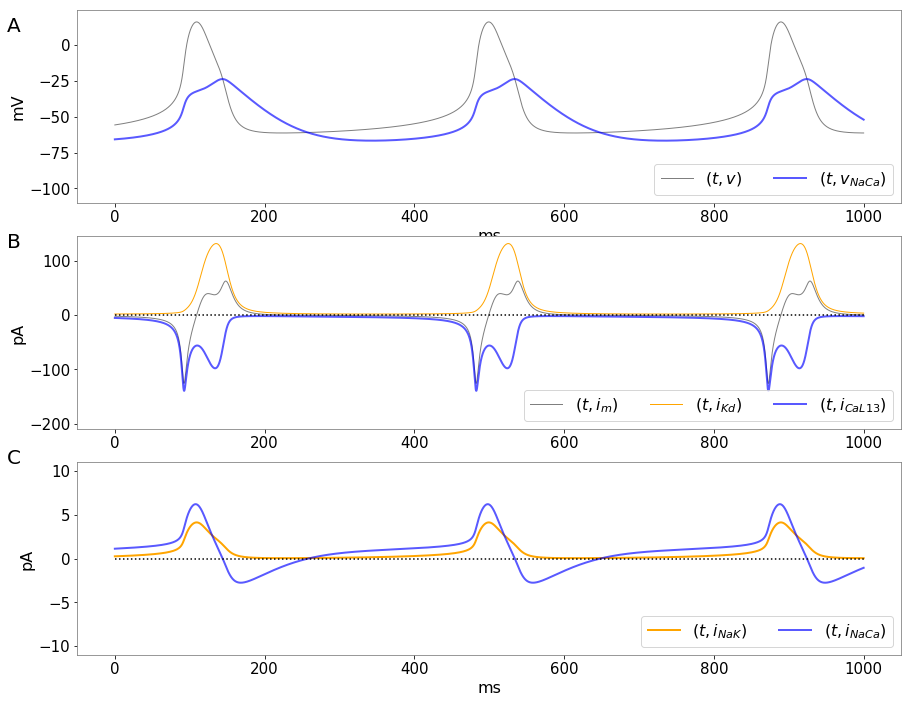

In [31]:
figCardiacPacemaking2=1
if figCardiacPacemaking2:
    f1= plotCardiacProfile2(d, figName='./ttt_Figures/sanPM.png', fs=16)

In [32]:
print(p3d)

{'in_Na': 15.0, 'out_Na': 140.0, 'in_Ka': 140.0, 'out_Ka': 5.0, 'out_Ca': 1500.0, 'in_Ca': 0.1, 'in_Cl': 10.0, 'out_Cl': 150.0, 'Cm': 30.0, 'tempCelcius': 37.0, 'v_ATP': -420.0, 'timeMin': 0.0, 'timeMax': 1000.0, 'timeStep': 0.02, 'rTol': 0.0001, 'aTol': 1e-09, 'eCharge': 1.60217733e-19, 'kBoltzmann': 1.38065812e-20, 'zeroT': 273.15, 'Faraday': 96485.3329, 'NA': 6.02214086e+23, 'eta_KaD': 1.0, 'a_KaD': 700.0, 'rect_KaD': 0.5, 'v_half_Act_KaD': 0.0, 'gain_Act_KaD': 3.0, 'rate_Act_KaD': 0.05, 'exp_Act_KaD': 1.0, 'bias_Act_KaD': 0.35, 'eta_NaT': -1.0, 'a_NaT': 0.001, 'rect_NaT': 0.5, 'v_half_Act_NaT': -25.0, 'gain_Act_NaT': 4.0, 'rate_Act_NaT': 10.0, 'exp_Act_NaT': 1.0, 'bias_Act_NaT': 0.3, 'v_half_Inac_NaT': -67.5, 'gain_Inac_NaT': -4.3, 'rate_Inac_NaT': 0.1, 'exp_Inac_NaT': 1.0, 'bias_Inac_NaT': 0.2, 'eta_Ca13': -2.0, 'a_Ca13': 1, 'rect_Ca13': 0.5, 'v_half_Act_Ca13': -18.0, 'gain_Act_Ca13': 4.0, 'rate_Act_Ca13': 10.0, 'exp_Act_Ca13': 1.0, 'bias_Act_Ca13': 0.3, 'eta_NaCa': -1.0, 'a_NaCa'

In [37]:
print('Max dv/dt = %g mV/ms'%d['dvdt'].max())
print('a_Ca=%g, a_KaD=%g, a_NaK=%g, a_NaCa=%g, all in pA'%(p3d['a_Ca13'],p3d['a_KaD'],p3d['a_NaKa'],p3d['a_NaCa']))
print('A_CaL=%g, A_KaD=%g, A_NaK=%g, A_NaCa=%g, all in V/s'%(p3d['a_Ca13']/p3d["Cm"],p3d['a_KaD']/p3d["Cm"],p3d['a_NaKa']/p3d["Cm"],p3d['a_NaCa']/p3d["Cm"]))

Max dv/dt = 4.197 mV/ms
a_Ca=1, a_KaD=700, a_NaK=1, a_NaCa=3, all in pA
A_CaL=0.0333333, A_KaD=23.3333, A_NaK=0.0333333, A_NaCa=0.1, all in V/s


#### Exploring the double activation of the calcium current

In [38]:
def plotICa(d, figName="iCa_doubleActivation.png", fs=16): 
    m13Inf = nExpSigmoid(p3d['gain_Act_Ca13']*(d['v']-p3d['v_half_Act_Ca13'])/p3d['v_T'])
    wInf = nExpSigmoid(p3d['gain_Act_KaD']*(d['v']-p3d['v_half_Act_KaD'])/p3d['v_T'])
    ssICa13= (1-wInf)*d["iCaL13"]/(1-d["w"])
    ssICa13Persistent= d["iCaL13"]/(1-d["w"])
    #
    fDA=gr.figure(figsize=(15,7)); gr.ioff(); rows=1; cols=2
    ax=list()
    ax.append(fDA.add_subplot(rows, cols, 2))
    #ax.append(ax[0].twiny())
    ax.append(fDA.add_subplot(rows, cols, 1))
    #ax[1].plot(d['v'],ssICa13,'red',lw=1,alpha=0.5, label=r'$(v,i_{CaL\infty})$')
    ax[1].plot(d['v'],ssICa13Persistent,'k',lw=5, alpha=0.25, label=r'$(v,i_{CaLP})$')
    ax[1].plot(d['v'],d["iCaL13"],'b',lw=1,alpha=0.85, label=r'$(v,i_{CaL})$')
    ax[0].plot(d['dvdt'],d["iCaL13"],'b',lw=1, alpha=0.65, label=r'$(\partial_t v,i_{CaL\infty})$')
    #ax[2].plot(d['w'],d["iCaL13"],'orange',lw=1, label=r'$(w,i_{CaL})$')
    ax[1].set_xlabel(r'$v$ (mV)',fontsize=fs); 
    ax[0].set_xlabel(r'$\partial_t v$ (V/s)',fontsize=fs)
    ax[1].set_ylabel(r'$i_{CaL}$ (pA)',fontsize=fs); 
    #ax[1].set_ylabel(r'$i_{CaL}$ (pA)',fontsize=fs); 
    ax[1].legend(loc='lower left',fontsize=fs); 
    ax[0].legend(loc='lower left',fontsize=fs)
    fDA.text(0.05,0.95,'A',fontsize=20)
    fDA.text(0.53,0.95,'B',fontsize=20)
    fDA.subplots_adjust(left=0.1, bottom=0.125, right=0.98, top=0.95, wspace=0.18, hspace=0.175)
    gr.ion(); gr.draw()
    if len(figName)>0:
        fDA.savefig(figName)
    
    return fDA

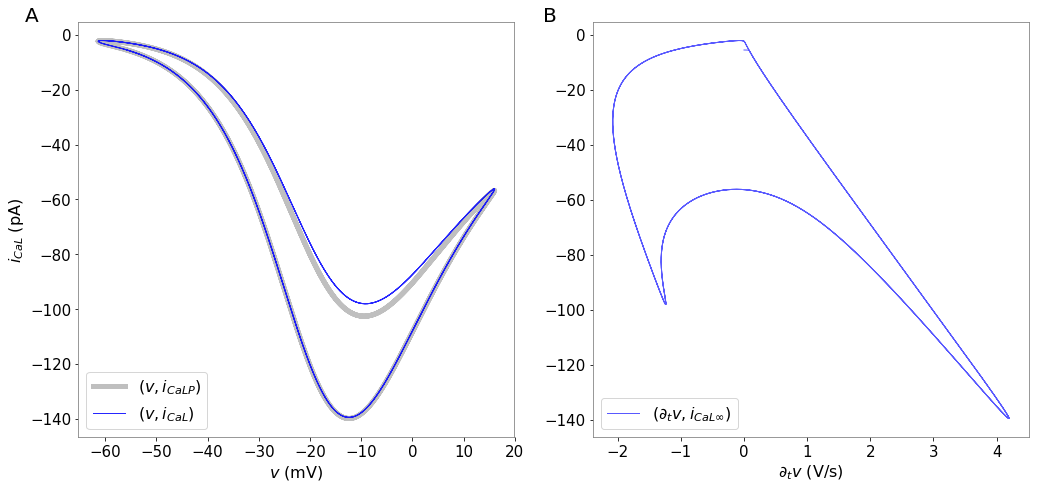

In [39]:
figICa=1
if figICa:
    f2= plotICa(d, figName="./ttt_Figures/iCa_doubleActivation.png", fs=16)
    #f2= plotICa(d, figName="", fs=15)

In [44]:
def plotCaProfile(d, figName2='', fs=15):
    f2=gr.figure(figsize=(15,7))
    ax1= f2.add_subplot(111); ax2 = ax1.twinx()
    ax1.plot(d['mSecs'], d["in_Ca"], 'k', lw=1, alpha =0.5, label=r'$(t,[Ca]_i)$')
    ax2.plot(d['mSecs'], d["v_Ca"], 'orange', lw=2, alpha=0.65, label=r'$(t,v_{Ca})$')
    ax2.plot(d['mSecs'], d["v_NaCa"], 'blue', lw=2, alpha=1, label=r'$(t,v_{NaCa})$')
    ax1.set_ylabel(r'$\mu$M',fontsize=fs); ax2.set_ylabel(r'$mV$',fontsize=fs)
    ax1.legend(loc='center left',fontsize=fs); ax2.legend(loc='center right',fontsize=fs)
    f2.subplots_adjust(left=0.1, bottom=0.085, right=0.9, top=0.98, wspace=0.15, hspace=0.175)
    if len(figName2)>0:
        f2.savefig(figName2)
    return f2

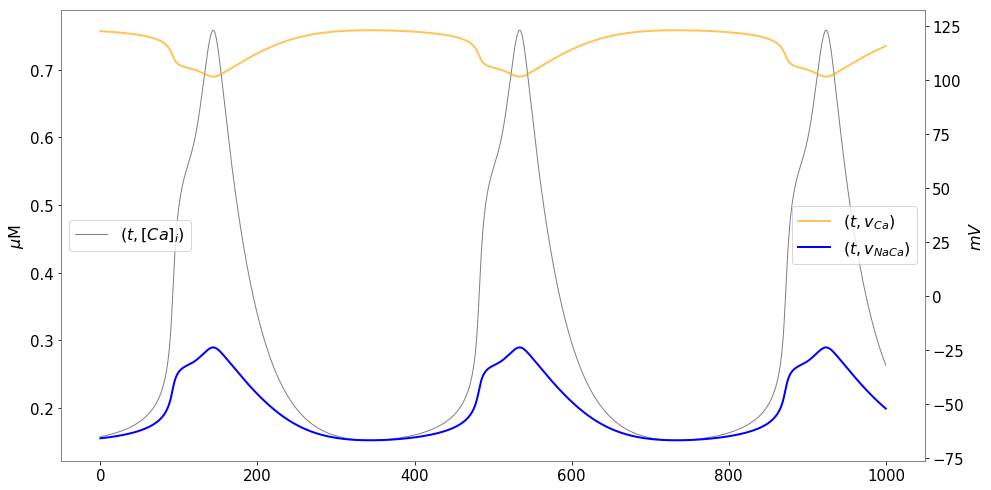

In [45]:
figCardiacPacemaking2=1
if figCardiacPacemaking2:
    f2= plotCaProfile(d,figName2='./ttt_Figures/sanPM_CaProfile.png', fs=16)

#### Ca-concentration profile 
This depends on the size of the parameters $k_c$, $r_c$, and $c_{in}$.

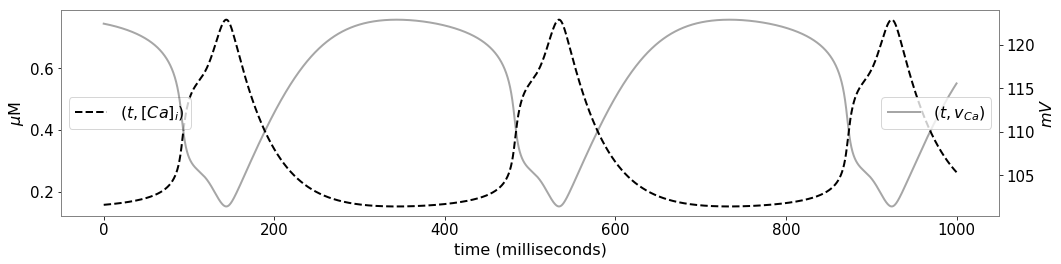

In [48]:
fs=16; 
f2=gr.figure(figsize=(15,7)); gr.ioff()
ax1= f2.add_subplot(211); ax2 = ax1.twinx()
ax1.plot(d['mSecs'], d["in_Ca"], 'k--', lw=2, label=r'$(t,[Ca]_i)$')
ax2.plot(d['mSecs'], d["v_Ca"], 'k', lw=2, alpha=0.35, label=r'$(t,v_{Ca})$')
ax1.set_ylabel(r'$\mu$M',fontsize=fs); ax2.set_ylabel(r'$mV$', fontsize=fs)
ax1.set_xlabel(r'time (milliseconds)', fontsize=fs)
ax1.legend(loc='center left',fontsize=fs); ax2.legend(loc='center right',fontsize=fs)
f2.tight_layout(); gr.ion(); gr.draw()


In [49]:
if 0:
    f2.savefig("./ttt_Figures/CaConcentrationProfile.png")

## 2D-Neuronal dynamics 

General minimal model for neuronal transmembrane potential
\begin{eqnarray}
\partial_t v &=& - (1-w) F_{m}(v) A_{NaT} (v) \psi_{NaT}(v) - w A_{Kd} \psi_{Kd}(v)- A_{NaK} \psi_{NaK}(v)
\\
\partial_t w &=& w \left( F_{w}(v) - w \right) R_w(v)
\end{eqnarray}
Auxiliary functions
\begin{eqnarray}
\psi_x (v) &=& a_x \delta_x \left[ \exp \left( b_x \frac{v_{R_x}-\delta_x v}{v_T} \right) -\exp \left( (b_x -1) \frac{v_{R_x} -\delta_x v}{v_T} \right) \right]
\quad x \in \left\{ NaT, Kd, NaK \right\}
\\
F_x (v) &=& \frac{\exp \left( g_x \frac{v-v_x}{v_T} \right) }{1+\exp \left( g_x \frac{v-v_x}{v_T} \right) }
\quad x \in \left\{ m,w \right\}
\\
R_w (v) &=& r_w \left[ \exp \left( b_w g_w \frac{v-v_w}{v_T} \right) +\exp \left( (b_w -1) g_w \frac{v-v_w}{v_T} \right) \right]
\end{eqnarray}



#### Functions to solve the equations modeling neurons

In [50]:
# ------------------------------------------
# 2D neuron with K-activation as slow variable
# ------------------------------------------
def NaTKaDNaKaLFP(u,p):
    v,w = u
    vvKaD = p['gain_Act_KaD']*(v-p['v_half_Act_KaD'])/p['v_T']
    wInf = nExpSigmoid(vvKaD)
    wRate = p['rate_Act_KaD'] * nExpSum(vvKaD,s=p['bias_Act_KaD'])
    mInf = nExpSigmoid(p['gain_Act_NaT']*(v-p['v_half_Act_NaT'])/p['v_T'])
    jKaD= genCurrent(v,p['v_Ka'], eta=p["eta_KaD"], rect=p["rect_KaD"], vT=p["v_T"],A=p["a_KaD"]*p["eta_KaD"],degree="exp")
    jNaT= genCurrent(v,-p['v_Na'], eta=p["eta_NaT"], rect=p["rect_NaT"],  vT=p["v_T"],A=p["a_NaT"]*mInf*p["eta_NaT"],degree=p["degree_KaD"])
    jNaKa= genCurrent(v,p['v_NaKa'], eta=p["eta_NaKa"], rect=p["rect_NaKa"],  vT=p["v_T"],A=p["a_NaKa"]*p["eta_NaKa"],degree=p["degree_NaKa"])
    dv = -((1-w)*jNaT + w*jKaD + jNaKa + p["jLFP"])/p["Cm"]
    dw = (w**p['exp_Act_KaD']) * wRate * (wInf-w)
    return sc.array([dv,dw])

def wInverse(w,vHalf,gCharge,vT):
    v= vHalf - (vT/gCharge) * sc.log( (1-w)/w)
    return v


def vNull(y,p):
    """v-Nullcline
    Notice the amplitudes for the current are not normalized
    """
    mInf = nExpSigmoid(p['gain_Act_NaT']*(y-p['y_half_Act_NaT']))
    jKaD= genCurrent(v,p['v_Ka'], eta=p["eta_KaD"], rect=p["rect_KaD"], vT=p["v_T"],A=p["a_KaD"]*p["eta_KaD"],degree="exp")
    jNaT= genCurrent(v,-p['v_Na'], eta=p["eta_NaT"], rect=p["rect_NaT"],  vT=p["v_T"],A=p["a_NaT"]*mInf*p["eta_NaT"],degree="exp")
    jNaKa= genCurrent(v,p['v_NaKa'], eta=p["eta_NaKa"], rect=p["rect_NaKa"],  vT=p["v_T"],A=p["a_NaKa"]*p["eta_NaKa"],degree="exp")
    return (jNaT + jNaKa)/(iNaT - iKaD)

def wNull(v,p):
    vvKaD = p['gain_Act_KaD']*(v-p['v_half_Act_KaD'])/p['v_T']
    return nExpSigmoid(vvKaD)


In [51]:
def RK2_Neuron(pars, f, ic, stepSize, nSteps,jLFP):
    """Second-order Runge-Kutta method to solve x' = f(x,t) with U(t[0]) = U0.
    NOTES:
        This version is based on the algorithm presented in "Numerical
        Analysis", 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
    """
    U=sc.zeros((nSteps, sc.prod(sc.shape(ic))),"float64")
    U[0]=ic
    for i in sc.arange(nSteps-1):
        pars["jLFP"]= jLFP[i]
        t = stepSize * i
        #print(f(U[i],pars))
        k1 = stepSize * f( U[i], pars) / 2.0
        U[i+1] = U[i] + stepSize * f( U[i] + k1, pars)
    return U.transpose()



In [52]:
# ------------------------------------------
# Solutions from the a 2D system modeling a neuron
# ------------------------------------------
def calc2DNrnOrbit(p,jLFP, graphs=1,fs=16, maxT=20, show_wInv=0,figName=''):
    """
    Examples:
    q=calc2DNrnOrbit(p,graphs=0)
    q=calc2DNrnOrbit(p,graphs=1)
    """
    orbit=RK2_Neuron(pars=p, f=p["rhs"], ic=p["ic"], stepSize=p["timeStep"], nSteps=len(p["timeSamples"]),jLFP=jLFP)
    v = orbit[0]; w = orbit[1]
    dvdt=sc.zeros(len(v)); dvdt[1:]= (v[1:]-v[:-1])/p["timeStep"]
    dwdt=sc.zeros(len(v)); dwdt[1:]= (w[1:]-w[:-1])/p["timeStep"]
    wInv= wInverse(w,vHalf=p["v_half_Act_KaD"],vT=p["v_T"],gCharge=p["gain_Act_KaD"])
    print("max dv/dt=%g"%(dvdt.max()))
    #print("orbit: ", orbit)
    vvKaD = p['gain_Act_KaD']*(v-p['v_half_Act_KaD'])/p['v_T']
    wInf = nExpSigmoid(vvKaD)
    wRate = p['rate_Act_KaD'] * nExpSum(vvKaD,s=p['bias_Act_KaD'])
    mInf = nExpSigmoid(p['gain_Act_NaT']*(v-p['v_half_Act_NaT'])/p['v_T'])
    jKaD= genCurrent(v,p['v_Ka'], eta=p["eta_KaD"], rect=p["rect_KaD"], vT=p["v_T"], A=p["a_KaD"]*p["eta_KaD"],degree="exp")
    jNaT= genCurrent(v,-p['v_Na'], eta=p["eta_NaT"], rect=p["rect_NaT"], vT=p["v_T"], A=p["a_NaT"]*mInf*p["eta_NaT"],degree="exp")
    jNaKa= genCurrent(v,p['v_NaKa'], eta=p["eta_NaKa"], rect=p["rect_NaKa"], vT=p["v_T"],A=p["a_NaKa"]*p["eta_NaKa"],degree="exp")
    iNaT = (1-w)*jNaT
    iKaD = w* jKaD    
    iNaKa = jNaKa    
    iTot= (iNaT+ iKaD + iNaKa)
    upInds = sc.where(dvdt>0)[0]
    dnInds = sc.where(dvdt<0)[0]
    rcNaT = iNaT.sum()/iTot.sum()
    rcKd = iKaD.sum()/iTot.sum()
    effNaT = iNaT[upInds].sum()/iTot[upInds].sum()
    effKd = iKaD[dnInds].sum()/iTot[dnInds].sum()
    print("Na efficiency = %g"%((effNaT)))
    print("K efficiency = %g"%((effKd)))
    #jAMPA = p["Cm"]*p['AMPA'](timeSamp) * nExpSub(y- p['y_r_AMPA'], s=p['bias_AMPA'])
    #jGabaA = p["Cm"]*p['GabaA'](timeSamp) * nExpSub(y- p['y_r_GabaA'], s=p['bias_GabaA'])
    q={"timeSamples":sc.arange(0,p2d['timeMax'],p2d['timeStep']),
       "v":v, "w":w, "dvdt":dvdt, "dwdt":dwdt, "wInv":wInv,
       "mInf":mInf, "wInf":wInf,
       "iNaT":iNaT, "iKaD":iKaD, "iNaKa":iNaKa, 
       "iTot":iTot, #"vNull":vNull, 
       #"jAMPA":jAMPA, "jGabaA":jGabaA
      }
    if graphs:
        maxC = sc.array([iNaT.max(),iKaD.max()]).max()
        f1=gr.figure(figsize=(17,11)); 
        f2=gr.figure(figsize=(17,11)); 
        q["fig1"]=f1; q["fig2"]=f2
        gr.ioff()
        ax=list()
        # Generar los planos para las graficas
        axV=f1.add_subplot(2,1,1)
        axC=f1.add_subplot(2,1,2)
        r=2; c=2
        for n in range(r*c):
            ax.append(f2.add_subplot(r,c,n+1))
        
        # Asignar a cada plano una grafica
        xx=wInv*p["rate_Act_KaD"]
        axV.plot(p['timeSamples'], v, 'k', lw=1, alpha=1.0, label=r'$(t,v)$'); 
        
        ax[0].plot(dvdt, v, 'k', lw=1, alpha=1.0, label=r'$(\partial_t v,v)$'); 
        ax[0].plot([dvdt.min(),dvdt.max()], [0,0], 'k:'); 
        ax[1].plot(w, v, 'k', lw=1, alpha=1.0, label=r'$(w,v)$'); 
        if show_wInv>0:
            axV.plot(p['timeSamples'], wInv, 'k', lw=3, alpha=0.35, label=r'$(t,w^{-1}(v))$'); 
            ax[1].plot(w, wInv, 'k', lw=3, alpha=0.35, label=r'$(w,w^{-1}(v))$'); 
            ax[0].plot(dvdt, wInv, 'k', lw=3, alpha=0.3, label=r'$(\partial_t v,w^{-1}(v))$'); 
    
        axC.plot(p['timeSamples'], iKaD, 'r', lw=2, alpha=1.0, label=r'$(t,i_{Kd})$'); 
        axC.plot(p['timeSamples'], iNaT, 'g', lw=2, alpha=1.0, label=r'$(t,i_{NaT})$');  
        axC.plot(p['timeSamples'], iNaKa, 'b', lw=2, alpha=1.0, label=r'$(t,i_{NaK})$'); 
        axC.plot(p['timeSamples'],iTot, 'k', lw=1, alpha=1.0,  label=r'$(t,i_{M})$'); 
        axC.plot([0,p['timeMax']], [0,0], 'k:'); 
        ax[2].plot(dvdt, iKaD, 'r', lw=2, alpha=1.0, label=r'$(\partial_t v,i_{Kd})$'); 
        ax[2].plot(dvdt, iNaT, 'g', lw=2, alpha=1.0, label=r'$(\partial_t v,i_{NaT})$');  
        ax[2].plot(dvdt, iNaKa, 'b', lw=2, alpha=1.0, label=r'$(\partial_t v,i_{NaK})$');        
        ax[2].plot(dvdt, iTot, 'k', lw=1, alpha=1.0, label=r'$(\partial_t v,i_{M})$');        
        ax[2].plot([dvdt.min(),dvdt.max()], [0,0], 'k:'); 
        ax[3].plot(xx, iKaD, 'r', lw=2, alpha=1.0, label=r'$(\partial_t w,i_{Kd})$'); 
        ax[3].plot(xx, iNaT, 'g', lw=2, alpha=1.0, label=r'$(\partial_t w,i_{NaT})$');  
        ax[3].plot(xx, iNaKa, 'b', lw=2, alpha=1.0, label=r'$(\partial_t w,i_{NaK})$');        
        ax[3].plot(xx, iTot, 'k', lw=1, alpha=1.0, label=r'$(\partial_t w,i_{M})$');        
        ax[3].plot([xx.min(),xx.max()], [0,0], 'k:'); 
        axV.legend(ncol=1,loc="upper right",fontsize=fs)
        axC.legend(ncol=1,loc="upper right",fontsize=fs)
        ax[0].legend(ncol=1,loc="lower right",fontsize=fs)
        ax[1].legend(ncol=1,loc="lower right",fontsize=fs)
        ax[2].legend(ncol=1,loc="upper right",fontsize=fs)
        ax[3].legend(ncol=1,loc="upper left",fontsize=fs)
        ax[2].set_ylim(-maxC,maxC)
        ax[3].set_ylim(-maxC,maxC)
        axV.set_ylabel('$v$ (mV)',fontsize=fs); axV.set_xlabel('ms',fontsize=fs); 
        axV.set_xlim(p["timeSamples"].min(),maxT); axC.set_xlim(p["timeSamples"].min(),maxT)
        axC.set_ylabel('nA',fontsize=fs); axC.set_xlabel('ms',fontsize=fs)
        ax[0].set_ylabel('$v$ (mV)',fontsize=fs); ax[0].set_xlabel('V/s',fontsize=fs); 
        ax[1].set_ylabel('$v$ (mV)',fontsize=fs); ax[1].set_xlabel('$w$',fontsize=fs); 
        ax[2].set_ylabel('pA',fontsize=fs); ax[2].set_xlabel('V/s',fontsize=fs)
        ax[3].set_ylabel('pA',fontsize=fs); ax[3].set_xlabel('$\partial_t w$ (1/s)',fontsize=fs)
        f1.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.13)
        f2.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.13)
        xStart=0.01; xDiv=0.485; yDiv=0.485
        f1.text(xStart,0.975,'A',fontsize=fs)
        f1.text(xStart,yDiv,'B',fontsize=fs)
        f2.text(xStart,0.975,'C',fontsize=fs)
        f2.text(xStart+xDiv,0.975,'D',fontsize=fs)
        f2.text(xStart,yDiv,'E',fontsize=fs)
        f2.text(xStart+xDiv,yDiv,'F',fontsize=fs)
        gr.ion(); gr.draw();
        if len(figName)>0:
            n1=figName[:-4]+'_p1.png'
            n2=figName[:-4]+'_p2.png'
            f1.savefig(n1)
            f2.savefig(n2)
            print("Saved figure to files %s and %s"%(n1,n2))
        
    return q

def printAmps(p):
    print("aNaT=%g, aKaD=%g, aNaK=%g, all in pA "%(p["a_NaT"],p["a_KaD"],p["a_NaKa"]))
    print("aKaD/aNaT=%g"%(p["a_KaD"]/p["a_NaT"]))
    return 

### Fitting for striatal FS interneurons

Tuning for mouse striatal PV+ FS interneurons Orduz, et al. 2013.

vRest=-70.0, Rin=0.4 GOhm, Cm = 30 pF, rheobase=50 pA

The somatic area is 4071.5 square microns
The somatic membrane capacitance is 30 pF
Input resistance=0.4 GOhm, a_m=66.8171 pF
max dv/dt=116.32
Na efficiency = 7.41246
K efficiency = 1.62649
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 


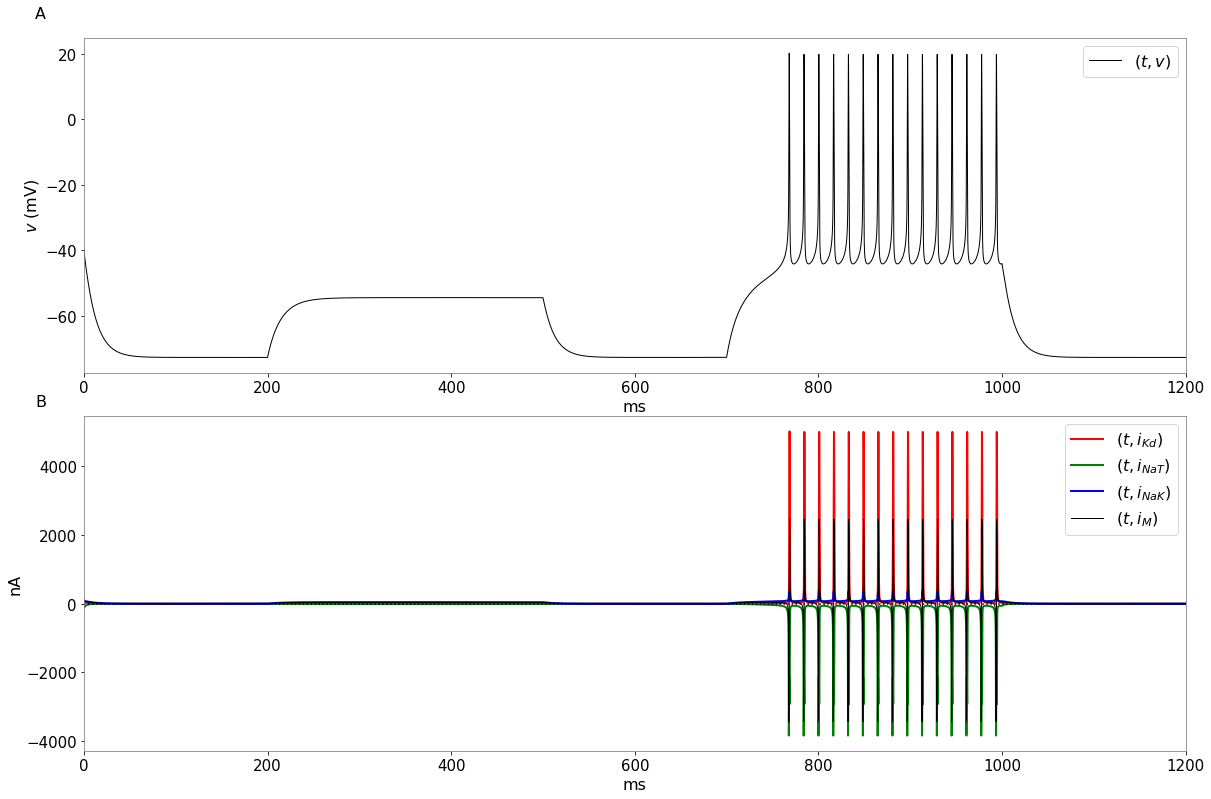

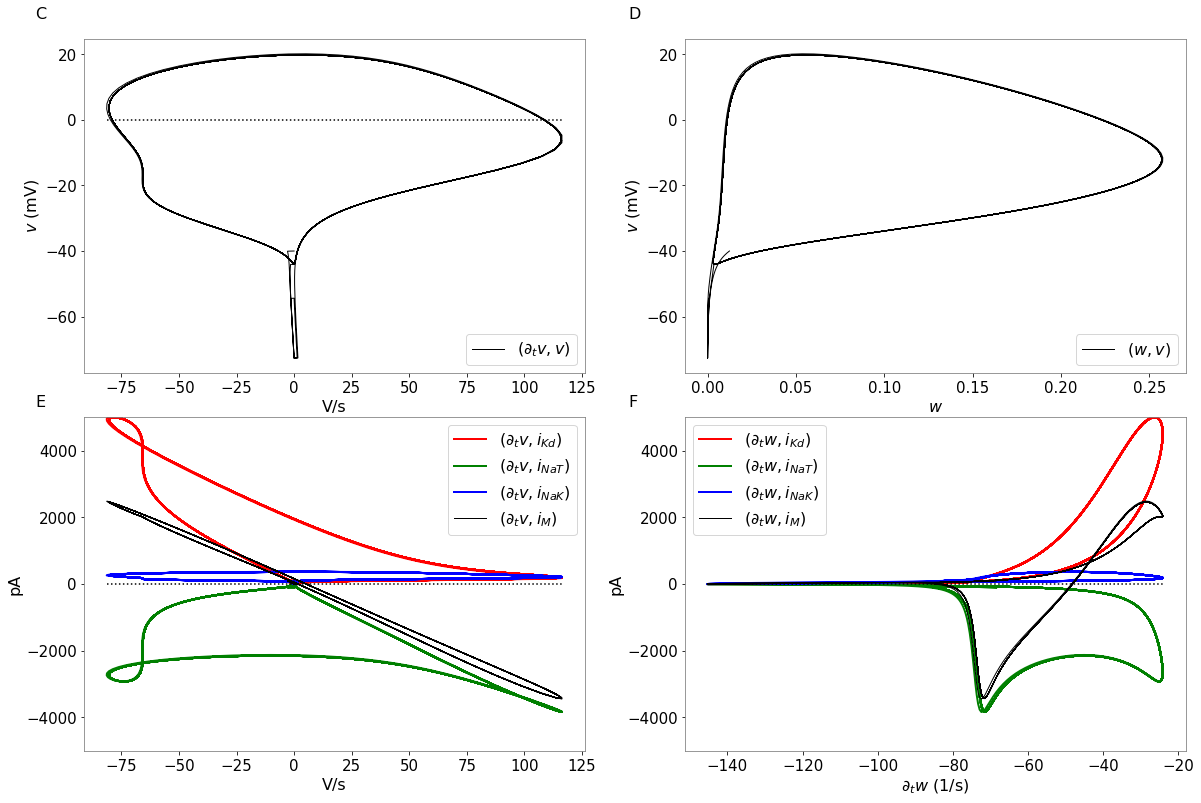

In [53]:
# -----------------------------------
# 2DNeuronal dynamics in more detail
# Tuning for mouse striatal PV+ FS interneurons Orduz, et al. 2013
# vRest=-70.0, Rin=0.4 GOhm, Cm = 30 pF, rheobase=50 pA
# -----------------------------------
if 1:
    p2d= p.copy()
    p2d['rhs']=NaTKaDNaKaLFP
    p2d["nDim"]=2; p2d["nNeur"]=1
    p2d['verboseSimulation']=0.
    p2d["degree"]="exp";p2d["degree_KaD"]="exp";p2d["degree_NaKa"]="exp"
    p2d["out_Ka"]=5.0;  p2d["in_Na"]=15.0; p2d["out_Na"]=140.0; p2d["v_ATP"]=-430.0
    somaRadius = 18.0
    somaArea = 4 * sc.pi * somaRadius**2 #um2
    p2d["sCm"] = 0.0075; # 0.07 uF/cm2 = 0.007 pF/um2
    p2d["Cm"] = p2d["sCm"] * somaArea
    p2d["Cm"] = 30 #pF
    print("The somatic area is %g square microns"%somaArea)
    print("The somatic membrane capacitance is %g pF"%p2d["Cm"])
    # Maximum current amplitudes in pA
    # For figures comparing single action potentials can use aNaT=1000, aKaD=4000, aNaK = 50
    p2d['a_NaT'] = 1400.0; 
    p2d['a_KaD'] = 4400.0 #* p2d["A_NaT"]
    #p2d['A_NaKa'] = 0.02 * p2d['A_NaT'] 
    p2d["Rin"]= 0.4 #GOhm
    print("Input resistance=%g GOhm, a_m=%g pF"%(p2d["Rin"],p2d["v_T"]/p2d["Rin"]))
    #*p2d["v_T"]/p2d["Rin"] #mV/GOhm = mV* nS = pF
    p2d["a_NaKa"] = p2d["v_T"]/p2d["Rin"] # Leak current from FS interneurons, mice Orduz, etal 2013
    p2d["rect_KaD"]=0.5; p2d['rate_Act_KaD'] = 2.; p2d["exp_Act_KaD"]=1.0; 
    p2d['bias_Act_KaD']=0.3 # longer delay for first spike at rheobase if closer to 0
    p2d['v_half_Act_KaD'] = -5.0; p2d['gain_Act_KaD'] = 4.0; 
    p2d['v_half_Act_NaT'] = -17.0; p2d['gain_Act_NaT'] = 5.0; 
    #p2d["jLFP"]=lambda t: -50.0 * sc.int32((t>200.0)&(t<700)) + -80.0  * sc.int32((t>1100.0)&(t<1600))
    p2d= calcReversalPotentials(p2d)
    p2d["timeStep"]= 1/50.0; p2d['timeMax']=1200.0
    p2d['timeSamples'] = sc.arange(0,p2d['timeMax'],p2d['timeStep'])
    stimFunction=lambda t: -40.0 * sc.int32((t>200.0)&(t<500)) -50.0 * sc.int32((t>700.0)&(t<1000)) -80.0  * sc.int32((t>1200.0)&(t<1700))
    jLFP=stimFunction(p2d["timeSamples"])
    v0 = -40.0
    w0 = nExpSigmoid(p['gain_Act_KaD']*(v0-p['v_half_Act_KaD'])/p['v_T'])
    p2d['ic']=[v0, w0]
    if 1: 
        q=calc2DNrnOrbit(p2d,maxT=p2d['timeMax'], graphs=1,jLFP=jLFP)
        printAmps(p2d)
        print("v_Na=%g, v_Ka=%g, v_NaKa=%g, "%(p2d["v_Na"],p2d["v_Ka"],p2d["v_NaKa"]))
        
        #sims= simulateKRectifyingAPs(p2d,graphs=1,figName="")
    #gr.show()
# -----------------------------------
baseParsFS = p2d.copy()

#### Rheobase protocol

Succesive stimulations with different amounts of external current of constant amplitude to find transitions between rest and spiking regimes

In [54]:
def iClampProtocol(pa):
    # Identifying a rheobase
    nStims=len(pa['stimAmps'])
    iClampSims = list()
    print("----------------\n")
    nSpikes=sc.zeros(nStims)
    for n in sc.arange(nStims):
        stimFunction=lambda t: pa['stimAmps'][n] * sc.int32((t>pa['stimStart'])&(t<pa['stimStop']))
        jLFP= stimFunction(pa["timeSamples"])
        pa= calcReversalPotentials(pa)
        q=calc2DNrnOrbit(pa,maxT=pa['timeMax'], graphs=0, jLFP=jLFP)
        q["Istim"]=pa['stimAmps'][n]
        iClampSims.append(q)
        str0=r'%g pA'%(-pa['stimAmps'][n])
        pa["iClampAx"].plot(q['timeSamples'],q['v'],pa["markers"][n],lw=pa["markerSizes"][n],alpha=pa["transparencies"][n], label=str0)
        pa["iClampAx"].legend(loc='upper left',fontsize=15)
        printAmps(pa)
        nSpikes[n]=len(findSpikes(q["dvdt"],100.0))
        print('Stimulus amplitude %s'%(str0))
        print("v_Na=%g, v_Ka=%g, v_NaKa=%g, "%(pa["v_Na"],pa["v_Ka"],pa["v_NaKa"]))
        print("Found %d spikes"%nSpikes[n])
        print("a_Na/C_m =%g A/F"%(pa["a_NaT"]/pa["Cm"]))
        print("----------------\n")
    return iClampSims

Fast spiking striatal (Tepper, Tecuapetla, Koos, Ibañez-Sandoval, 2007, or cortical, or hippocampal) interneuron.

In [55]:
p2d= baseParsFS
print(p2d)

{'in_Na': 15.0, 'out_Na': 140.0, 'in_Ka': 140.0, 'out_Ka': 5.0, 'out_Ca': 2.0, 'in_Ca': 0.0001, 'in_Cl': 10.0, 'out_Cl': 150.0, 'Cm': 30, 'tempCelcius': 37.0, 'v_ATP': -430.0, 'timeMin': 0.0, 'timeMax': 1200.0, 'timeStep': 0.02, 'rTol': 0.0001, 'aTol': 1e-09, 'eCharge': 1.60217733e-19, 'kBoltzmann': 1.38065812e-20, 'zeroT': 273.15, 'Faraday': 96485.3329, 'NA': 6.02214086e+23, 'eta_KaD': 1.0, 'a_KaD': 4400.0, 'rect_KaD': 0.5, 'v_half_Act_KaD': -5.0, 'gain_Act_KaD': 4.0, 'rate_Act_KaD': 2.0, 'exp_Act_KaD': 1.0, 'bias_Act_KaD': 0.3, 'eta_NaT': -1.0, 'a_NaT': 1400.0, 'rect_NaT': 0.5, 'v_half_Act_NaT': -17.0, 'gain_Act_NaT': 5.0, 'rate_Act_NaT': 10.0, 'exp_Act_NaT': 1.0, 'bias_Act_NaT': 0.3, 'v_half_Inac_NaT': -67.5, 'gain_Inac_NaT': -4.3, 'rate_Inac_NaT': 0.1, 'exp_Inac_NaT': 1.0, 'bias_Inac_NaT': 0.2, 'eta_Ca13': -2.0, 'a_Ca13': 0.0, 'rect_Ca13': 0.5, 'v_half_Act_Ca13': -20.0, 'gain_Act_Ca13': 4.0, 'rate_Act_Ca13': 10.0, 'exp_Act_Ca13': 1.0, 'bias_Act_Ca13': 0.3, 'eta_NaCa': -1.0, 'a_NaCa

### Rheobase protocol

----------------

max dv/dt=0
Na efficiency = nan
K efficiency = 0.1377
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 0 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 0 spikes
a_Na/C_m =46.6667 A/F
----------------



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


max dv/dt=1.33199
Na efficiency = -0.26027
K efficiency = 0.113414
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 40 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 0 spikes
a_Na/C_m =46.6667 A/F
----------------

max dv/dt=116.455
Na efficiency = 2.50349
K efficiency = 1.6901
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 50 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 27 spikes
a_Na/C_m =46.6667 A/F
----------------

max dv/dt=122.969
Na efficiency = 1.84685
K efficiency = 1.80144
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 80 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 67 spikes
a_Na/C_m =46.6667 A/F
----------------



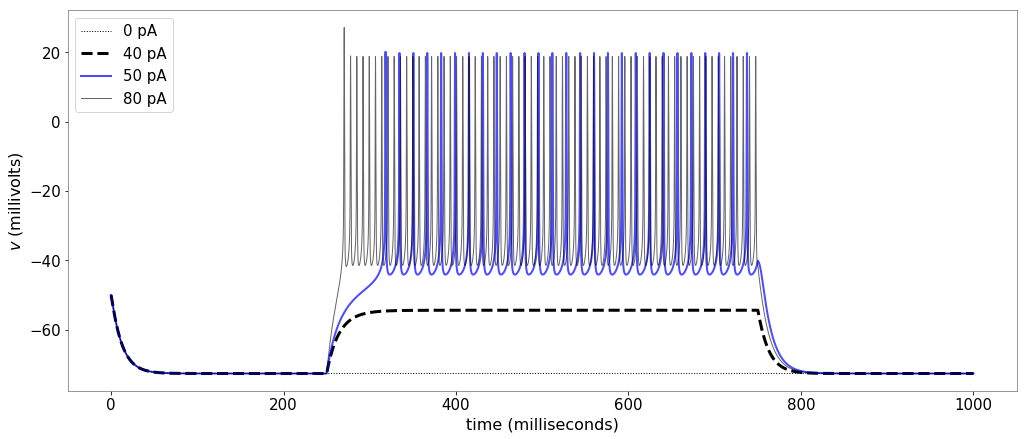

In [56]:
# Initial conditions and other relevant parameters
v0 = -50.0
w0 = nExpSigmoid(p2d['gain_Act_KaD']*(v0-p2d['v_half_Act_KaD'])/p2d['v_T'])
p2d['ic']=[v0, w0]
# Stimulus start and stop
p2d['stimStart']=250.0; p2d['stimStop']=750.0
#p2d['stimAmps']= -sc.arange(-5,220,50)
p2d['stimAmps']= sc.array([0,-40,-50,-80])
# Setup time samples for numerical solution
p2d= calcReversalPotentials(p2d)
p2d["timeStep"]= 1/40.0; p2d['timeMax']=1000.0
p2d['timeSamples'] = sc.arange(0,p2d['timeMax'],p2d['timeStep'])
# Identifying a rheobase
p2d["markers"]= ["k","k","k","k",]
p2d["markers"]= ["k:","k--","b","k",]
p2d["markerSizes"]= [1,3,2,1]
p2d["transparencies"]= [0.99,1,0.7,0.6]
iClampFig=gr.figure(figsize=(17,7)); gr.ioff()
p2d["iClampAx"]=iClampFig.add_subplot(111)
iClampSims = iClampProtocol(pa=p2d)
p2d["iClampAx"].set_xlabel(r"time (milliseconds)",fontsize=16)
p2d["iClampAx"].set_ylabel(r"$v$ (millivolts)",fontsize=16)
gr.ion(); gr.draw()

In [57]:
if 1: 
    iClampFig.savefig("ttt_Figures/FSNeuron_iClamp.png")


__What happens to the firing if when potassium channels are inward rectifiers?__

Firing still starts at stimulus amplitudes similar to rheobase, but at a higher rate. The interval for the stimulus amplitude in which the resting potential corresponds to an attracting node seems to srink. A around rheobase, the resting potential corresponds to focus points. Inward rectifier K channels are more effective in changing the membrane potential than sodium channels.


----------------

max dv/dt=0
Na efficiency = nan
K efficiency = 0.115594
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 0 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 0 spikes
a_Na/C_m =46.6667 A/F
----------------



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


max dv/dt=1.33199
Na efficiency = -0.288644
K efficiency = 0.0954023
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 40 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 0 spikes
a_Na/C_m =46.6667 A/F
----------------

max dv/dt=119.447
Na efficiency = 1.74207
K efficiency = 2.13198
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 50 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 137 spikes
a_Na/C_m =46.6667 A/F
----------------

max dv/dt=123.829
Na efficiency = 1.90257
K efficiency = 2.32011
aNaT=1400, aKaD=4400, aNaK=66.8171, all in pA 
aKaD/aNaT=3.14286
Stimulus amplitude 80 pA
v_Na=59.6968, v_Ka=-89.0592, v_NaKa=-72.791, 
Found 6 spikes
a_Na/C_m =46.6667 A/F
----------------



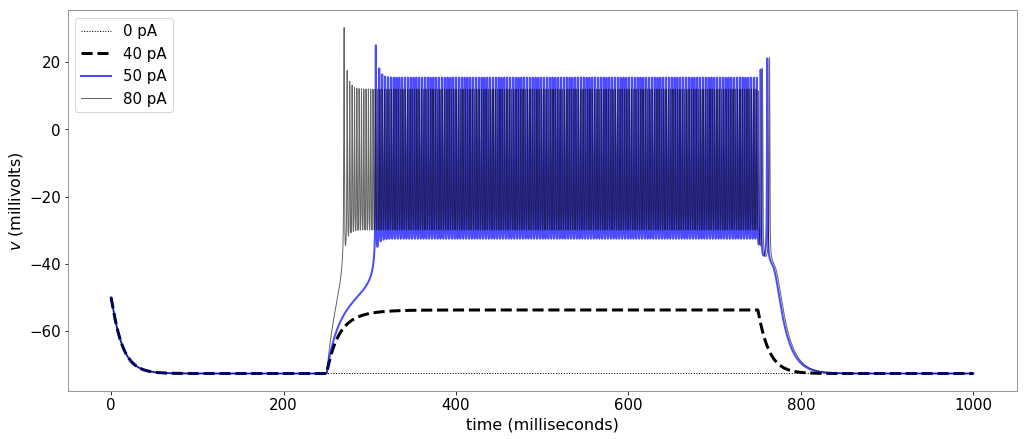

In [58]:
# Initial conditions and other relevant parameters
p2d= baseParsFS
v0 = -50.0
w0 = nExpSigmoid(p2d['gain_Act_KaD']*(v0-p2d['v_half_Act_KaD'])/p2d['v_T'])
p2d['ic']=[v0, w0]
# Inward rectification
p2d["rect_KaD"]=0.3
# Stimulus start and stop
p2d['stimStart']=250.0; p2d['stimStop']=750.0
p2d['stimAmps']= sc.array([0,-40,-50,-80])
# Setup time samples for numerical solution
p2d= calcReversalPotentials(p2d)
p2d["timeStep"]= 1/40.0; p2d['timeMax']=1000.0
p2d['timeSamples'] = sc.arange(0,p2d['timeMax'],p2d['timeStep'])
# Identifying a rheobase
p2d["markers"]= ["k","k","k","k",]
p2d["markers"]= ["k:","k--","b","k",]
p2d["markerSizes"]= [1,3,2,1]
p2d["transparencies"]= [0.99,1,0.7,0.6]
iClampFig=gr.figure(figsize=(17,7)); gr.ioff()
p2d["iClampAx"]=iClampFig.add_subplot(111)
iClampSims = iClampProtocol(pa=p2d)
p2d["iClampAx"].set_xlabel(r"time (milliseconds)",fontsize=16)
p2d["iClampAx"].set_ylabel(r"$v$ (millivolts)",fontsize=16)
gr.ion(); gr.draw()

Notes:
1. The reversal potential for the NaK current, or the  is very important for the spiking dynamics. Specifically, the increase in the baseline with current stimulation is more realistic for v_ATP below -430 mV.
2. In an appropriate regime, the effect of decreasing the slope of the steady state sodium current activation is to increase the firing rate. 

__What happens to the firing if when potassium channels are outward rectifiers?__

Firing still starts at stimulus amplitudes similar to rheobase, but at a lower rate, with a much longer delay to first spike. There seems to be a hard transition between the attracting nodes and the attracting focus points for small changes in the stimulus amplitude. The rheobase increases. Outward potassium channels seem to be less effective than sodium channels. 

In [ ]:
# Initial conditions and other relevant parameters
p2d= baseParsFS
v0 = -50.0
w0 = nExpSigmoid(p2d['gain_Act_KaD']*(v0-p2d['v_half_Act_KaD'])/p2d['v_T'])
p2d['ic']=[v0, w0]
# Inward rectification
p2d["rect_KaD"]=0.75
# Stimulus start and stop
p2d['stimStart']=250.0; p2d['stimStop']=1250.0
p2d['stimAmps']= sc.array([0,-40,-50,-80])
# Setup time samples for numerical solution
p2d= calcReversalPotentials(p2d)
p2d["timeStep"]= 1/40.0; p2d['timeMax']=1500.0
p2d['timeSamples'] = sc.arange(0,p2d['timeMax'],p2d['timeStep'])
# Identifying a rheobase
p2d["markers"]= ["k","k","k","k",]
p2d["markers"]= ["k:","k--","b","k",]
p2d["markerSizes"]= [1,3,2,1]
p2d["transparencies"]= [0.99,1,0.7,0.6]
iClampFig=gr.figure(figsize=(17,7)); gr.ioff()
p2d["iClampAx"]=iClampFig.add_subplot(111)
iClampSims = iClampProtocol(pa=p2d)
p2d["iClampAx"].set_xlabel(r"time (milliseconds)",fontsize=16)
p2d["iClampAx"].set_ylabel(r"$v$ (millivolts)",fontsize=16)
gr.ion(); gr.draw()